# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2020


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [3]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    # Create a padding so that the size of the image after tiling is greater to or equal to out_size
    padding = (int)(patch_size * np.ceil(out_size / patch_size) - out_size)
    
    # Create a blank square image of size out_size + padding 
    out_img = np.zeros([out_size + padding, out_size + padding, 3], dtype='uint8')
    
    for r in range((int)(np.ceil(out_size / patch_size))):
        for c in range((int)(np.ceil(out_size / patch_size))):
            
            # row, col location of top left corner of randomly sampled patch
            in_r = (int)(random() * (sample.shape[0] - patch_size))
            in_c = (int)(random() * (sample.shape[1] - patch_size))
            
            out_r = r * patch_size
            out_c = c * patch_size
            out_img[out_r:(out_r + patch_size), 
                    out_c:(out_c + patch_size), :] = sample[in_r:(in_r + patch_size), 
                                                            in_c:(in_c + patch_size), :]
    
    # trim padding from image and return
    return np.array(out_img[0:out_size, 0:out_size, :])


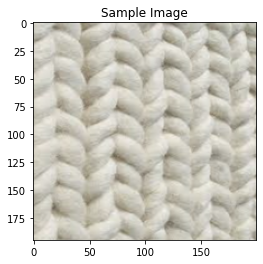

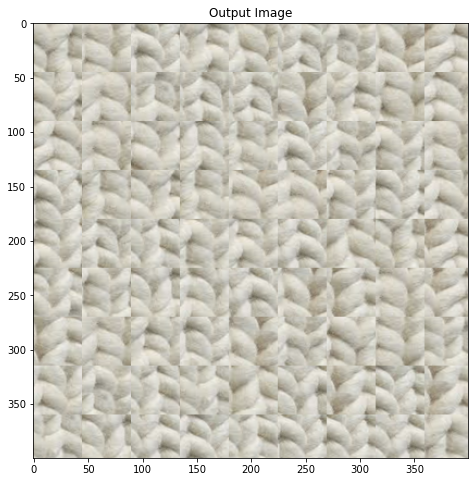

In [4]:
sample_img_fn = 'samples/texture.png' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.title('Sample Image')
plt.show()

out_size = 400  # change these parameters as needed
patch_size = 45

res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.figure(figsize=(8,8))
    plt.title('Output Image')
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [5]:
def ssd_patch(T, M, I):
    """
    Inputs:
        T: A patch template of the current portion of the output image that is to be 
            filled in
        M: A mask that is the same size as the patch template, with 1s in overlapping 
            region and 0s elsewhere
        I: The sample image
    Outputs:
        Returns the cost of sampling each patch based on the sum of squared differences
        of the overlapping regions of the existing and sampled patch
    """
    return ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)

In [6]:
def choose_sample(cost_img, patch_size, tol): 
    '''
    Inputs:
        cost_img:numpy.ndarray  A cost image
        tol:int                 A tolerance for choosing a random low cost value from cost_img
    Outputs:
        Returns the coordinates for the upper-left pixel of the patch to be 
        sampled from the sample image
    '''
    max_cost = np.max(cost_img)
    
    # Add a large value to the edges of the cost image so that only patches that fit entirely within 
    # the sample image will be chosen
    cost_img[:(int)(np.ceil(patch_size/2)), :] = max_cost
    cost_img[(int)(-np.ceil(patch_size/2)):, :] = max_cost
    cost_img[:, :(int)(np.ceil(patch_size/2))] = max_cost
    cost_img[:, (int)(-np.ceil(patch_size/2)):] = max_cost
    
    # Compute the indices of sorted values in flattened cost_img
    cost_sorted_ind = np.argsort(cost_img, axis=None)
    
    # Get index of tol smallest cost to choose from
    choices = cost_sorted_ind[:tol]
    
    # Choose a random value from choices
    choice = choices[(int)(random() * tol)]
    
    # Get the 2D indices of the 1D choice index. This is the location of the center 
    # pixel of the patch to be sampled
    in_r, in_c = np.unravel_index(choice, cost_img.shape)
    
    return in_r - (patch_size // 2), in_c - (patch_size // 2)

In [7]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an 
    output image of size outsize.
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    # Create a padding so that the size of the image after tiling is greater 
    # than or equal to out_size
    padding = (int)(patch_size * np.ceil(out_size / (patch_size - overlap)) - out_size)
    
    # Create a blank square image of size out_size + padding 
    out_img = np.zeros([out_size + padding, out_size + padding, 3])
    
    #randomly sample patch for the upper-left corner of the output image
    in_r = (int)(random() * (sample.shape[0] - patch_size))
    in_c = (int)(random() * (sample.shape[1] - patch_size))        
    out_img[:patch_size, :patch_size, :] = sample[in_r:(in_r + patch_size), 
                                                  in_c:(in_c + patch_size), :]

    # Fill top row of the output image
    for c in range(1, (int)(np.ceil(out_size / (patch_size - overlap)))):
        out_c = c * (patch_size - overlap)
        mask = np.zeros([patch_size, patch_size, 3])
        mask[:, :overlap, :] = 1
        template = out_img[:patch_size, out_c:(out_c + patch_size), :]
        
        # Create a cost image by computing SSD between template patch and 
        # image for each channel and summing the result
        cost_img = sum(ssd_patch(template[:, : , i], 
                                 mask[:, : , i], 
                                 sample[:, : , i]) for i in range(3))
        
        # Choose a random low cost sample
        in_r, in_c = choose_sample(cost_img, patch_size, tol)
        
        # Copy the pixels of the chosen sample into the next position in the output image
        out_img[:patch_size, out_c:(out_c+patch_size), :] = sample[in_r:(in_r+patch_size), 
                                                                   in_c:(in_c+patch_size), :]
    
    # Fill the remaining rows of the output image
    for r in range(1, (int)(np.ceil(out_size / (patch_size - overlap)))):
        
        # Fill first column of each row
        out_r = r * (patch_size - overlap)
        mask = np.zeros([patch_size, patch_size, 3])
        mask[:overlap, :, :] = 1
        template = out_img[out_r:(out_r + patch_size), :patch_size, :]
                    
        # Create a cost image by computing SSD between template patch and 
        # image for each channel and summing the result
        cost_img = sum(ssd_patch(template[:, : , i],
                                 mask[:, : , i], 
                                 sample[:, : , i]) for i in range(3))
        
        # Choose a random low cost sample
        in_r, in_c = choose_sample(cost_img, patch_size, tol)
        
        # Copy the pixels of the chosen sample into the next position in the output image
        out_img[out_r:(out_r+patch_size), :patch_size, :] = sample[in_r:(in_r+patch_size), 
                                                                   in_c:(in_c+patch_size), :]
        
        for c in range((int)(np.ceil(out_size / (patch_size - overlap)))):
        
            # Fill remaining columns in each row
            out_r = r * (patch_size - overlap)
            out_c = c * (patch_size - overlap)
            mask = np.zeros([patch_size, patch_size, 3])
            mask[:, :overlap, :] = 1
            mask[:overlap, :, :] = 1
            template = out_img[out_r:(out_r + patch_size), out_c:(out_c + patch_size), :]
            
            # Create a cost image by computing SSD between template patch and 
            # image for each channel and summing the result
            cost_img = sum(ssd_patch(template[:, : , i], 
                                     mask[:, : , i], 
                                     sample[:, : , i]) for i in range(3))
            
            # Choose a random low cost sample
            in_r, in_c = choose_sample(cost_img, patch_size, tol)

            # Copy the pixels of the chosen sample into the next position in the output image
            out_img[out_r:(out_r+patch_size), 
                    out_c:(out_c+patch_size), :] = sample[in_r:(in_r+patch_size), 
                                                          in_c:(in_c+patch_size), :]
        
    # Trim padding from image and return
    return np.array(out_img[0:out_size, 0:out_size, :])

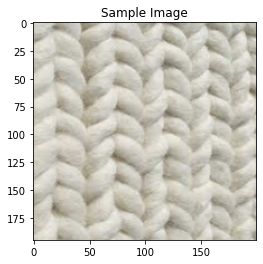

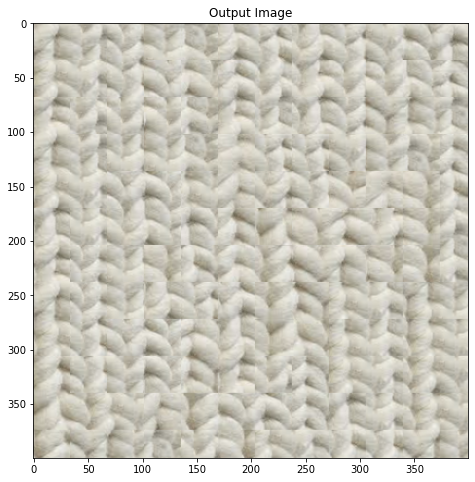

In [8]:
sample_img_fn = 'samples/texture.png' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB) / 255
plt.imshow(sample_img)
plt.title('Sample Image')
plt.show()

out_size = 400
patch_size = 45
overlap = 11
tol = 5

res = quilt_simple(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(8,8))
    plt.title('Output Image')
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [9]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [10]:
def build_patch_left_overlap(new_patch, existing_patch, overlap):
    '''
    Inputs:
        new_patch:numpy.ndarray      The new patch taken from the sampel image
        existing_patch:numpy.ndarry  The previous patch that was added to the output image
        overlap:int                  The pixel width of the overlapping region
    Outputs:
        Returns the patch that is to be added to the output image
    '''
    
    overlap_existing = existing_patch[:,:overlap,:] # The portion of the overlap from  existing patch
    overlap_new = new_patch[:,:overlap,:]           # The portion of the overlap from the new patch

    # Compute the cost of a path through each pixel
    ssd_overlap = sum((overlap_existing[:,:,i] - overlap_new[:,:,i])**2 for i in range(3))
    
    # Find the minimum cost contiguous path across the overlapping portion of 
    # the image and create a mask with 1s for the portion of the new patch to be 
    # added and 0s for the portion of the existing image to remain
    mask_new = np.transpose(cut(np.transpose(ssd_overlap)))
        
    # Build the right side of the overlap region by multiplying the mask 
    # by each channel in the sample patch portion of the overlap
    overlap_new = cv2.merge([mask_new * overlap_new[:,:,0],  
                             mask_new * overlap_new[:,:,1], 
                             mask_new * overlap_new[:,:,2]])

    # Create a mask with 1s for the portion of the left image to be added 
    # by inverting the right side mask
    mask_existing = 1 - mask_new

    # Build the left side of the overlap region by multiplying the mask 
    # by each channel in the portion of the overlap region that is from the current out_img
    overlap_existing = cv2.merge([mask_existing * overlap_existing[:,:,0], 
                                  mask_existing * overlap_existing[:,:,1],
                                  mask_existing * overlap_existing[:,:,2]])

    # Creat the new overlap region by adding the left and right side together
    overlap_whole = overlap_existing + overlap_new
        
    # Create the patch by concatenating the overlap with the non-overlapping portion 
    # of the sample patch
    patch = np.concatenate((overlap_whole, new_patch[:,overlap:,:]), axis=1)
    
    return patch

In [11]:
def build_patch_top_overlap(new_patch, existing_patch, overlap):  
    '''
    Inputs:
        new_patch:numpy.ndarray      The new patch taken from the sampel image
        existing_patch:numpy.ndarry  The previous patch that was added to the output image
        overlap:int                  The pixel width of the overlapping region
    Outputs:
        Returns the patch that is to be added to the output image
    '''
    overlap_existing = existing_patch[:overlap,:,:]    # The portion of the overlap from existing patch
    overlap_new = new_patch[:overlap,:,:]              # The portion of the overlap from the new patch
        
    # Compute the cost of a path through each pixel
    ssd_overlap = sum((overlap_existing[:,:,i] - overlap_new[:,:,i])**2 for i in range(3))
    
    # Find the minimum cost contiguous path across the overlapping portion of 
    # the image and create a mask with 1s for the portion of the new patch to 
    # be added and 0s for the portion of the existing image to remain
    mask_new = cut(ssd_overlap)

    # Build the right side of the overlap region by multiplying the mask by each channel in the sample patch
    # portion of the overlap
    overlap_new = cv2.merge([mask_new * overlap_new[:,:,0], 
                             mask_new * overlap_new[:,:,1], 
                             mask_new * overlap_new[:,:,2]])

    # Create a mask with 1s for the portion of the left image to be 
    #added by inverting the right side mask
    mask_existing = 1 - mask_new

    # Build the left side of the overlap region by multiplying the mask by 
    #each channel in the portion of the overlap region that is from the current out_img
    overlap_existing = cv2.merge([mask_existing * overlap_existing[:,:,0], 
                                  mask_existing * overlap_existing[:,:,1],
                                  mask_existing * overlap_existing[:,:,2]])
    
    # Create the new overlap region by adding the left and right side together
    overlap_whole = overlap_existing + overlap_new

    # Create the patch by concatenating the overlap with the non-overlapping 
    # portion of the sample patch
    patch = np.concatenate((overlap_whole, new_patch[overlap:,:,:]), axis=0)
    
    return patch

In [12]:
def build_patch_left_top_overlap(new_patch, existing_patch, overlap):
    '''
    Inputs:
        new_patch:numpy.ndarray      The new patch taken from the sampel image
        existing_patch:numpy.ndarry  The previous patch that was added to the output image
        overlap:int                  The pixel width of the overlapping region
    Outputs:
        Returns the patch that is to be added to the output image
    '''
    overlap_existing_top = existing_patch[:overlap,:,:]  # The portion of the top overlap from existing image
    overlap_new_top = new_patch[:overlap,:,:]            # The portion of the top overlap from the new patch
    overlap_existing_left = existing_patch[:,:overlap,:] # The portion of the left overlap from existing image
    overlap_new_left = new_patch[:,:overlap,:]           # The portion of the left overlap from the new patch
     
    # Compute the cost of a path through each pixel
    ssd_overlap_top = sum((overlap_existing_top[:,:,i] - 
                           overlap_new_top[:,:,i])**2 for i in range(3))
    ssd_overlap_left = sum((overlap_existing_left[:,:,i] - 
                            overlap_new_left[:,:,i])**2 for i in range(3))
    
    # Find the minimum cost contiguous path across the overlapping portion of 
    # the image and create a mask with 1s for the portion of the new patch 
    # to be added and 0s for the portion of the existing image to remain
    mask_new_top = cut(ssd_overlap_top)
    mask_new_left = np.transpose(cut(np.transpose(ssd_overlap_left)))
    
    # Create a mask for the portion of cuts that overlap in the upper left corner
    mask_new_top_left= np.logical_and(mask_new_top[:, :overlap], mask_new_left[:overlap, :])
    
    # Replace the top of the left side mask with the correct corner mask
    mask_new_left = np.concatenate((mask_new_top_left, mask_new_left[overlap:, :]), axis=0)
    
    mask_new_right = np.concatenate((mask_new_top[:,overlap:], 
                                     np.ones((mask_new_left.shape[0]-overlap, 
                                              new_patch.shape[1]-overlap))), axis=0)
    
    # Create complete mask for the portion of the patch from the texture sample
    mask_new = np.concatenate((mask_new_left, mask_new_right), axis=1)
    
    # Create complete mask for the portion of the patch from the output image
    mask_existing = 1 - mask_new
    
    overlap_new = cv2.merge([mask_new * new_patch[:, :, 0], 
                             mask_new * new_patch[:, :, 1], mask_new * new_patch[:, :, 2]])
    overlap_existing = cv2.merge([mask_existing * existing_patch[:, :, 0],
                                  mask_existing * existing_patch[:, :, 1], 
                                  mask_existing * existing_patch[:, :, 2]])
    
    patch = overlap_new + overlap_existing    
    
    return patch

In [13]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam 
    finding in order to create an output image of size outsize.
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    # Create a padding so that the size of the image after tiling is 
    # greater than or equal to out_size
    padding = (int)(patch_size * np.ceil(out_size / (patch_size - overlap)) - out_size)
    
    # Create a blank square image of size out_size + padding 
    out_img = np.zeros([out_size + padding, out_size + padding, 3])
    
    #randomly sample patch for the upper-left corner of the output image
    in_r = (int)(random() * (sample.shape[0] - patch_size))
    in_c = (int)(random() * (sample.shape[1] - patch_size))        
    out_img[:patch_size, :patch_size, :] = sample[in_r:(in_r + patch_size), 
                                                  in_c:(in_c + patch_size), :]

    # Fill top row of the output image
    for c in range(1, (int)(np.ceil(out_size / (patch_size - overlap)))):
        out_c = c * (patch_size - overlap)
        mask = np.zeros([patch_size, patch_size, 3])
        mask[:, :overlap, :] = 1
        template = out_img[:patch_size, out_c:(out_c + patch_size), :]
        
        # Create a cost image by computing SSD between template patch 
        # and image for each channel and summing the result
        cost_img = sum(ssd_patch(template[:, :, i], mask[:, :, i], 
                                 sample[:, :, i]) for i in range(3))
        
        # Choose a random low cost sample
        in_r, in_c = choose_sample(cost_img, patch_size, tol)
        
        # Create the patch from the sample image
        new_patch = build_patch_left_overlap(sample[in_r:(in_r+patch_size), 
                                                    in_c:(in_c+patch_size), :], template, overlap)
        
        # Copy the pixels of the chosen sample into the next position in the output image
        out_img[:patch_size, out_c:(out_c+patch_size), :] = new_patch
    
    # Fill the remaining rows of the output image
    for r in range(1, (int)(np.ceil(out_size / (patch_size - overlap)))):
        
        # Fill first column of each row
        out_r = r * (patch_size - overlap)
        mask = np.zeros([patch_size, patch_size, 3])
        mask[:overlap, :, :] = 1
        template = out_img[out_r:(out_r + patch_size), :patch_size, :]
        
        # Create a cost image by computing SSD between template patch 
        # and image for each channel and summing the result
        cost_img = sum(ssd_patch(template[:, :, i], mask[:, :, i], 
                                 sample[:, :, i]) for i in range(3))
        
        # Choose a random low cost sample
        in_r, in_c = choose_sample(cost_img, patch_size, tol)
        
        # Create the patch from the sample image
        new_patch = build_patch_top_overlap(sample[in_r:(in_r+patch_size), in_c:(in_c+patch_size), :], template, overlap)
        
        # Copy the pixels of the chosen sample into the next position in the output image
        out_img[out_r:(out_r+patch_size), :patch_size, :] = new_patch
        
        for c in range((int)(np.ceil(out_size / (patch_size - overlap)))):
            
            # Fill remaining columns in each row
            out_r = r * (patch_size - overlap)
            out_c = c * (patch_size - overlap)
            mask = np.zeros([patch_size, patch_size, 3])
            mask[:, :overlap, :] = 1
            mask[:overlap, :, :] = 1
            template = out_img[out_r:(out_r + patch_size), out_c:(out_c + patch_size), :]
            
            # Create a cost image by computing SSD between template patch and 
            # image for each channel and summing the result
            cost_img = sum(ssd_patch(template[:, : , i], mask[:, : , i], 
                                     sample[:, : , i]) for i in range(3))

            # Choose a random low cost sample
            in_r, in_c = choose_sample(cost_img, patch_size, tol)
            
            # Create the patch from the sample image
            new_patch = build_patch_left_top_overlap(sample[in_r:(in_r+patch_size), 
                                                            in_c:(in_c+patch_size), :], template, overlap)
            
            # Copy the pixels of the chosen sample into the next position in the output image
            out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size), :] = new_patch
            
    # Trim padding from image and return
    return np.array(out_img[0:out_size, 0:out_size, :])
    

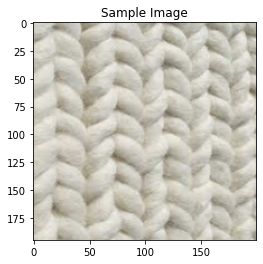

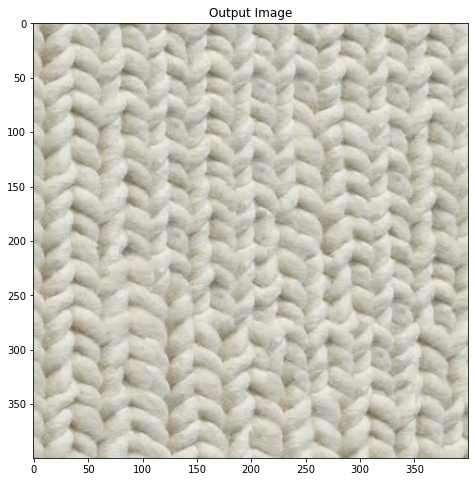

In [14]:
sample_img_fn = 'samples/texture.png' 
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB) / 255
plt.imshow(sample_img)
plt.title('Sample Image')
plt.show()

out_size = 400  # change these parameters as needed
patch_size = 45
overlap = 11
tol = 5
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.figure(figsize=(8,8))
    plt.title('Output Image')
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [15]:
def texture_transfer(sample, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order 
    to create an output image of size outsize.
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    # Convert target and sample images to grayscale
    target_gray = cv2.cvtColor(guidance_im, cv2.COLOR_BGR2GRAY)
    texture_gray = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
    
    # Normalize values in sample
    sample = sample / 255
    
    # Apply Gaussian blur to target and sample
    ksize = (21, 21)
    sigma = 5
    target_gray_blur = cv2.GaussianBlur(target_gray, ksize, sigma) / 255
    texture_gray_blur = cv2.GaussianBlur(texture_gray, ksize, sigma) /255
    
    height = guidance_im.shape[0]
    width = guidance_im.shape[1]

    # Create a padding so that the size of the image after tiling is 
    # greater than or equal to the size of the target image
    padding_w = (int)(patch_size * np.ceil(width / (patch_size - overlap)) - width)
    padding_h = (int)(patch_size * np.ceil(height / (patch_size - overlap)) - height)
    
    # Create a blank square image that is the same size as the output image + padding
    out_img = np.zeros([height + padding_h, width + padding_w, 3])  
    
    # Add padding to right and bottom of blurred target image
    target_gray_blur = np.concatenate((target_gray_blur, 
                                       np.ones([target_gray_blur.shape[0], padding_w])), axis=1)
    target_gray_blur = np.concatenate((target_gray_blur, 
                                       np.ones([padding_h, target_gray_blur.shape[1]])), axis=0)
    
    # Compute cost between luminance of blurred target image and blurred texture
    template_target = target_gray_blur[:patch_size, :patch_size]
    ssd_transfer = ssd_patch(template_target, np.ones([patch_size, patch_size]), 
                             texture_gray_blur)
    
    # Choose a random low cost patch
    in_r, in_c = choose_sample(ssd_transfer, patch_size, tol)
    
    # Place the chosen patch from the texture in the upper left corner of the output image
    out_img[:patch_size, :patch_size, :] = sample[in_r:(in_r + patch_size), 
                                                  in_c:(in_c + patch_size), :]
    
    # Fill top row of the output image
    for c in range(1, (int)(np.ceil(width / (patch_size - overlap)))):
        out_c = c * (patch_size - overlap)
        mask = np.zeros([patch_size, patch_size, 3])
        mask[:, :overlap, :] = 1
        template = out_img[:patch_size, out_c:(out_c + patch_size), :]
        
        # Compute cost between existing output and sample
        ssd_overlap = sum(ssd_patch(template[:, :, i], mask[:, :, i], 
                                    sample[:, :, i]) for i in range(3))
        
        # Compute cost between luminance of blurred target image and blurred texture
        template_target = target_gray_blur[:patch_size, out_c:(out_c + patch_size)]
        ssd_transfer = ssd_patch(template_target, np.ones([patch_size, patch_size]), 
                                 texture_gray_blur)
        
        # Compute an error that is the weighted sum of the two SSDs
        cost_img = alpha * ssd_overlap + (1 - alpha) * ssd_transfer
        
        # Choose a random low cost sample
        in_r, in_c = choose_sample(cost_img, patch_size, tol)
        
        # Create the patch from the sample image
        new_patch = build_patch_left_overlap(sample[in_r:(in_r+patch_size), 
                                                    in_c:(in_c+patch_size), :], template, overlap)
        
        # Copy the pixels of the chosen sample into the next position in the output image
        out_img[:patch_size, out_c:(out_c+patch_size), :] = new_patch
    
    # Fill the remaining rows of the output image
    for r in range(1, (int)(np.ceil(height / (patch_size - overlap)))):
        
        # Fill first column of each row
        out_r = r * (patch_size - overlap)
        mask = np.zeros([patch_size, patch_size, 3])
        mask[:overlap, :, :] = 1
        template = out_img[out_r:(out_r + patch_size), :patch_size, :]

        # Compute cost between existing output and sample
        ssd_overlap = sum(ssd_patch(template[:, :, i], mask[:, :, i], 
                                    sample[:, :, i]) for i in range(3))
        
        # Compute cost between luminance of blurred target image and blurred texture
        template_target = target_gray_blur[out_r:(out_r + patch_size), :patch_size]
        ssd_transfer = ssd_patch(template_target, 
                                 np.ones([patch_size, patch_size]), texture_gray_blur)
        
        # Compute an error that is the weighted sum of the two SSDs
        cost_img = alpha * ssd_overlap + (1 - alpha) * ssd_transfer
        
        # Choose a random low cost sample
        in_r, in_c = choose_sample(cost_img, patch_size, tol)
        
        # Create the patch from the sample image
        new_patch = build_patch_top_overlap(sample[in_r:(in_r+patch_size), 
                                                   in_c:(in_c+patch_size), :], template, overlap)
        
        # Copy the pixels of the chosen sample into the next position in the output image
        out_img[out_r:(out_r+patch_size), :patch_size, :] = new_patch
        
        for c in range((int)(np.ceil(width / (patch_size - overlap)))):
            
            # Fill remaining columns in each row
            out_r = r * (patch_size - overlap)
            out_c = c * (patch_size - overlap)
            mask = np.zeros([patch_size, patch_size, 3])
            mask[:, :overlap, :] = 1
            mask[:overlap, :, :] = 1
            template = out_img[out_r:(out_r + patch_size), out_c:(out_c + patch_size), :]
            
            # Compute cost between existing output and sample
            ssd_overlap = sum(ssd_patch(template[:, :, i], mask[:, :, i], 
                                        sample[:, :, i]) for i in range(3))
            
            # Compute cost between luminance of blurred target image and blurred texture
            template_target = target_gray_blur[out_r:(out_r + patch_size), 
                                               out_c:(out_c + patch_size)]
            ssd_transfer = ssd_patch(template_target, 
                                     np.ones([patch_size, patch_size]), texture_gray_blur)
            
            # Compute an error that is the weighted sum of the two SSDs
            cost_img = alpha * ssd_overlap + (1 - alpha) * ssd_transfer
            
            # Choose a random low cost sample
            in_r, in_c = choose_sample(cost_img, patch_size, tol)
            
            # Create the patch from the sample image
            new_patch = build_patch_left_top_overlap(sample[in_r:(in_r+patch_size), 
                                                            in_c:(in_c+patch_size), :], template, overlap)
            
            # Copy the pixels of the chosen sample into the next position in the output image
            out_img[out_r:(out_r+patch_size), out_c:(out_c+patch_size), :] = new_patch
        
    # Trim padding from image and return
    return np.array(out_img[:height, :width, :])
    

In [16]:
# load/process appropriate input texture and guidance images
texture_img_fn = 'samples/pillow.jpg' 
guidance_img_fn = 'samples/Greg.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

patch_size = 25
overlap = 9
tol = 1
alpha = 0.5
res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)

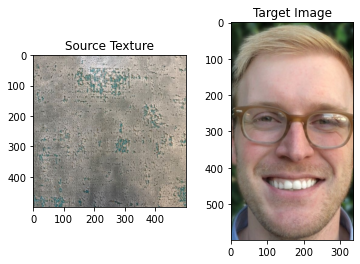

In [17]:
fig, axs = plt.subplots(1,2)
axs[0].set_title('Source Texture')
axs[0].imshow(texture_img)
axs[1].set_title('Target Image')
axs[1].imshow(guidance_img)

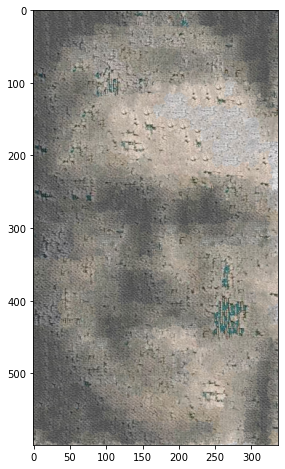

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(res) 
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

In [19]:
texture_img_fn = 'samples/pillow.jpg' 
guidance_img_fn = 'samples/Greg.jpg'
texture_img = cv2.cvtColor(cv2.imread(texture_img_fn), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

N = 4
tol = 1
for i in range(N):
    patch_size = int(np.ceil(251 / (3 ** i)))
    overlap = patch_size // 3
    alpha = 0.8 * i/(N - 1) + 0.1
    res = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
    
    # set the guidance image for the next iteration to be the synthesized image just produced
    guidance_im = cv2.cvtColor(np.array(res * 255, dtype='uint8'), cv2.COLOR_RGB2BGR)

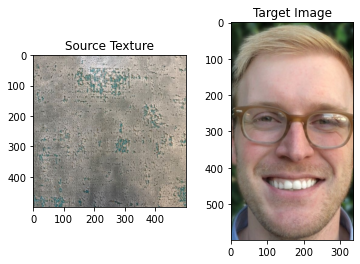

In [20]:
fig, axs = plt.subplots(1,2)
axs[0].set_title('Source Texture')
axs[0].imshow(texture_img)
axs[1].set_title('Target Image')
axs[1].imshow(guidance_img)

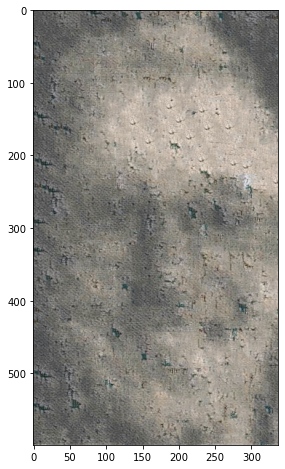

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(res) 
plt.show()

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

In [ ]:
background_img_fn = 'samples/toast.jpg' 
guidance_img_fn = 'samples/Greg.jpg'
background_img = cv2.cvtColor(cv2.imread(background_img_fn), cv2.COLOR_BGR2RGB)
guidance_img = cv2.cvtColor(cv2.imread(guidance_img_fn), cv2.COLOR_BGR2RGB)

# Create a texture image by cropping the edge of the toast out
texture_img = background_img[50:450, 50:450]

N = 4
tol = 1
for i in range(N):
    patch_size = int(np.ceil(171 / (3 ** i)))
    overlap = patch_size // 3
    alpha = 0.8 * i/(N - 1) + 0.1
    foreground_img = texture_transfer(texture_img, patch_size, overlap, tol, guidance_img, alpha)
    guidance_im = cv2.cvtColor(np.array(res * 255, dtype='uint8'), cv2.COLOR_RGB2BGR)

In [ ]:
fig, axs = plt.subplots(1,2)
axs[0].set_title('Source Texture'), axs[0].set_xticks([]), axs[0].set_yticks([])
axs[0].imshow(texture_img)
axs[1].set_title('Guidance Image'), axs[1].set_xticks([]), axs[1].set_yticks([])
axs[1].imshow(guidance_img)

plt.figure(figsize=(10,10))
plt.imshow(foreground_img) 
plt.show()

In [ ]:
# Downscale foreground image to fit insde of gackground image
scaled_height = 410
scale = scaled_height / foreground_img.shape[0]
width = int(foreground_img.shape[1] * scale)
height = int(foreground_img.shape[0] * scale)
dim = (width, height)
foreground_scaled = cv2.resize(foreground_img, dim, interpolation = cv2.INTER_LINEAR)

# Add a border of 0s around the downscaled foreground image, making the image the 
#same size as the background image
border_r = np.zeros([int((background_img.shape[0]-foreground_scaled.shape[0])/2), 
                     foreground_scaled.shape[1], 3])
border_c = np.zeros([background_img.shape[0], 
                     int((background_img.shape[1]-foreground_scaled.shape[1])/2), 3])

fg = np.concatenate([border_r, foreground_scaled, border_r], axis=0)
fg = np.concatenate([border_c, fg, border_c], axis=1)
#fg = np.array(fg.copy() * 255, dtype='uint8')

# Create a mask containing 0s for the background source and 1s for the pixels being 
# coppied from the foreground source
mask = np.zeros([background_img.shape[0], background_img.shape[1], 3])
mask[int((background_img.shape[0]-foreground_scaled.shape[0])/2)+10:
     int((background_img.shape[0]+foreground_scaled.shape[0])/2)-10,
     int((background_img.shape[1]-foreground_scaled.shape[1])/2)+10:
     int((background_img.shape[1]+foreground_scaled.shape[1])/2)-10, :] = 1

In [ ]:
def gauss_lap_pyr(img, depth):
    '''
    Inputs:
        img:numpy.ndarray  An image
        depth:int          The number of levels of the Laplacian and Gaussian pyramid
    Outputs:
        Returns the Laplacian and Gaussian pyramids for the input image
    '''
    sigma = 1.5
    ksize = (int(np.ceil(sigma)) * 6 + 1, int(np.ceil(sigma)) * 6 + 1)
    
    gauss_pyr = [img]
    lap_pyr = []
    blur_pyr = [cv2.GaussianBlur(img, ksize, sigma)]
    
    for i in range(depth - 1):
        G = cv2.resize(blur_pyr[i], None, fx=0.5, fy=0.5)
        gauss_pyr.append(G)
        blur_pyr.append(cv2.GaussianBlur(G, ksize, sigma))
        
    for i in range(depth - 1):
        L = gauss_pyr[i] - blur_pyr[i]
        lap_pyr.append(L)
    
    lap_pyr.append(gauss_pyr[depth - 1])
    
    return gauss_pyr, lap_pyr

In [ ]:
# Normalize background image
bg = background_img / 255

pyr_depth = 6                                 # number of levels of the laplacian pyramid
fg_lap_pyr = gauss_lap_pyr(fg, pyr_depth)[1]  # list that stores the laplacian pyramid of the forefround image
bg_lap_pyr = gauss_lap_pyr(bg, pyr_depth)[1]  # list that stores the laplacian pyramid of the backfround image
mask_gauss_pyr = gauss_lap_pyr(mask, pyr_depth)[0]  # list that stores the gaussian pyramid of the mask image

# Combine the foreground and bacground image per the mask at each level of the laplacian pyramids
L = [fg_lap_pyr[i] * mask_gauss_pyr[i] + bg_lap_pyr[i] *
     (1 - mask_gauss_pyr[i]) for i in range(pyr_depth)]

# Reconstruct the image from the laplacian pyramid of the combined foreground/background
L_recon = [L[pyr_depth-1]]
sigma = 1.5
ksize = (int(np.ceil(sigma)) * 6 + 1, int(np.ceil(sigma)) * 6 + 1)
for i in range(pyr_depth - 1):
    L_up = cv2.resize(L_recon[i], dsize=(L[pyr_depth-i-2].shape[1], L[pyr_depth-i-2].shape[0]))
    L_up_smooth = cv2.GaussianBlur(L_up, ksize, sigma)
    L_recon.append(L_up_smooth + L[pyr_depth-i-2])

In [ ]:
# Display inputs for Laplacian pyramid blending
fig, axs = plt.subplots(1,3, figsize=(10,8))
axs[0].set_title('Foreground Image'), axs[0].set_xticks([]), axs[0].set_yticks([])
axs[0].imshow(fg)
axs[1].set_title('Background Image'), axs[1].set_xticks([]), axs[1].set_yticks([])
axs[1].imshow(bg)
axs[2].set_title('Mask'), axs[2].set_xticks([]), axs[2].set_yticks([])
axs[2].imshow(mask)

In [ ]:
# Display face-in-toast image
plt.figure(figsize=(15,15))
plt.imshow(L_recon[pyr_depth - 1])
plt.show()

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).